# Synchornization in complete networks of neurons
Here is the dynamics of neurons potentails in rotational model :
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) -g  E \\
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
num_neurons = 10000
g = 3
random_input_span = (9.5,13.5) #it should fall in the well defined cos(\theta) domain.

total_time = 100
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

theta_arr = np.zeros(num_neurons,dtype = float)
# theta_arr = np.random.uniform(0,np.pi,size = num_neurons)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
theta_sum = np.zeros(num_neurons)
theta_e_product_sum = np.zeros(num_neurons)

In [4]:
saving_path_name = 'single_runs'
current_version = 'N{}_T{}_g{}_input_{}_{}'.format(num_neurons,total_time,g,random_input_span[0],random_input_span[1])
try:
    saving_path = os.path.join(saving_path_name, current_version) 
    os.makedirs(saving_path)
except:
    pass

In [5]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )
amin_saman_param = np.zeros( total_steps )

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [6]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

In [7]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0


## "For" loop on the march!
To make equations more solvable we turn them into three cases of linear first order equations:
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) - g E \\
\dot{E} = M - \alpha E\\
\dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [8]:
for i in tqdm( range(total_steps - 1) ):
    #dynamic
    theta_arr = theta_arr + (random_input - np.cos(theta_arr) - g * e_arr[i] )*time_step
    
    # Prevent neurons from free falling to large negative degrees.
#     free_fall_mask = theta_arr < - 25*np.pi/2
#     theta_arr[free_fall_mask] = -25*np.pi/2 + 0.1
    
    #here we should spot the spiking neurons.
    spiking_records[i] = theta_arr > np.pi
    theta_arr = theta_arr - 2 * np.pi * spiking_records[i]

    
    #neurons activity
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )
    
    #
    left_handed_neurons = np.cos(theta_arr) < 0
    amin_saman_param[i] = np.mean( np.sin(theta_arr[left_handed_neurons]) )**2
    
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones
    
    #temporal correlation between theta states and inner-neuron current
    theta_sum += theta_arr
    theta_e_product_sum += theta_arr*e_arr[i+1]
    
    

  0%|                                                                                         | 0/9999 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:06<00:00, 1666.41it/s]


In [9]:
sigma = np.std( e_arr )
sigma

0.2083294751238272

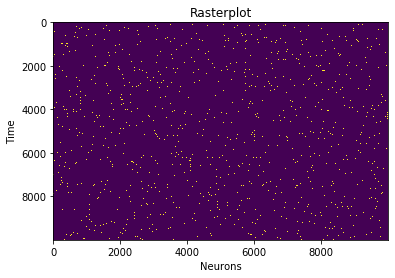

In [10]:
plt.imshow( spiking_records, aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig( os.path.join(saving_path, 'raster_plot.png'))

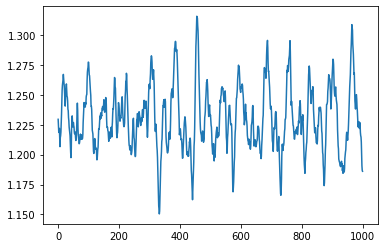

In [11]:
plt.plot(e_arr[-1000:])

## Calculate frequnecy

In [12]:
spikies_period_mean = total_spikes_intervals * time_step / total_spikes_num
spikies_period_mean;

In [13]:
heights, bins = np.histogram(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))

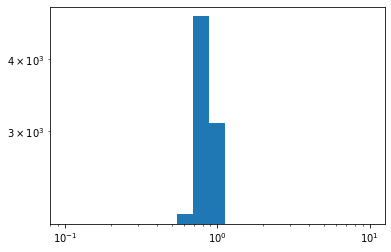

In [14]:
(heights, bins, patches) = plt.hist(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
plt.yscale('log')
plt.xscale('log')

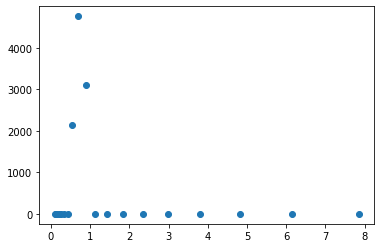

In [15]:
plt.scatter(bins[:-1],heights)

plt.savefig( os.path.join(saving_path, 'spikies_time_interval.png'))

## Are silent neurons the lower recieved inputs?

Text(0.5, 1.0, 'Activity vs constant input')

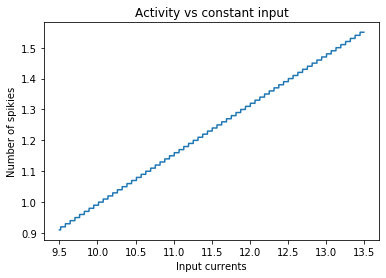

In [16]:
plt.plot(np.sort(random_input), total_spikes_num[ np.argsort(random_input) ]/total_time )
plt.xlabel('Input currents')
plt.ylabel('Number of spikies')
plt.title('Activity vs constant input')
# plt.savefig(os.path.join(saving_path, 'spikies_num_vs_input.png'))

### Curve fitting

This section we will try to fit a f(I) curve on the neurons response data.
$$
f(I) = a \frac{\sqrt{[b(I - I_0 )]^2 - 1}}{2\pi}
$$

In [17]:
from scipy.optimize import curve_fit

In [18]:
def response_func(i,a,b,i0):
    if type(i) == int:
        returned_value = a*(b**2 * (i-i0)**2 - 1)**(1/2) / 2*np.pi
    else:
        returned_value = np.zeros(len(i))
        for index in range(len(i)):
            if i[index] > 1/b + i0:
                returned_value[index] = a*(b**2 * (i[index]-i0)**2 - 1)**(1/2) / 2*np.pi
    return returned_value

In [19]:
xdata = np.sort(random_input)
ydata = total_spikes_num[ np.argsort(random_input) ]/total_time # not total steps

# popt, popv = curve_fit(response_func,xdata,ydata, bounds = (0,[20,20,20]))
popt, popv = curve_fit(response_func,xdata,ydata)

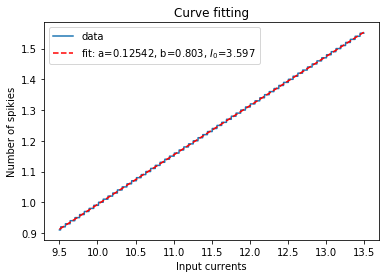

In [20]:
fig,ax = plt.subplots()
ax.plot(xdata, ydata, label = 'data')
ax.plot(xdata, response_func(xdata, *popt), 'r--', label='fit: a=%5.5f, b=%5.3f, $I_0$=%5.3f' % tuple(popt))
plt.legend()
ax.set_xlabel('Input currents')
ax.set_ylabel('Number of spikies')
ax.set_title('Curve fitting')
plt.savefig(os.path.join(saving_path, 'spikies_num_vs_input_fitted_curve.png'))

## Current Estimation with I_0
$$
F_{mean} == \sum_i f_{mean}(I_i - I_0)\\
I_{mean_{l}} == -g F_{mean} / N
$$

In [21]:
xdata = np.sort(random_input)
i_0 = popt[2]
-g * np.mean( response_func(xdata, popt[0],popt[1], i_0 )  )

-3.6923490071818743

In [22]:
i_0

3.5973571114142446

In [23]:
g*np.mean(e_arr[-1000:])

3.6907085743668295

## Current calculation

Analytical current says:
$$
<I_{in}>_t = -g \int_{a_{min}}^{a_{max}} p(a) <f(a + I_{in})>_t da 
$$
do this recursion actually happen?

In [24]:
i_in_avg = np.mean( -g* e_arr[-1000:] )
i_in_avg

-3.69070857436683

In [25]:
def single_neuron_response(current_array):
    return_response = np.zeros(len(current_array))
    for index in range(len(current_array)):
        if current_array[index] > 1:
            return_response[index] =  np.sqrt(current_array[index]**2 - 1)/ (2*np.pi)
    return return_response

def analytical_current(i_exp_arr):
    computed_current = np.zeros(len(i_exp_arr))
    for index in range(len(i_exp_arr)):
        computed_current[index] = -g * np.mean( single_neuron_response(random_input + i_exp_arr[index] ) )
    return computed_current

In [26]:
i_in_suspect_range = np.linspace(-13,-8,100)
# analytical_current(i_in_suspect_range)

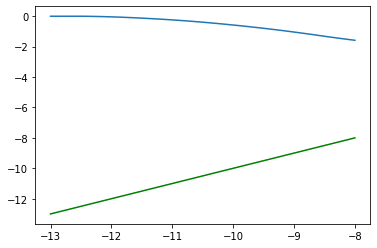

In [27]:
plt.plot(i_in_suspect_range, analytical_current(i_in_suspect_range))
plt.plot(i_in_suspect_range, i_in_suspect_range, 'g')

# Fast Fourier Transform of E current.

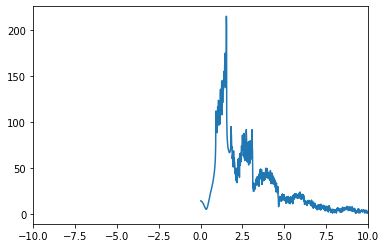

In [28]:
e_freq_amplitude_abs = np.abs( np.fft.fft(e_arr) )[1:e_arr.size//2]
e_freq = np.fft.fftfreq(e_arr.size, d = time_step)[1:e_arr.size//2]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlim((-10,10))
ax.plot(e_freq, e_freq_amplitude_abs)


# Poiancare Map: Local Maxima
In this section we will plot (n+1)-th maxima versus the n-th maxima

In [29]:
from scipy.signal import argrelextrema

In [30]:
e_local_maxima_ind = argrelextrema(e_arr[1000:], np.greater)[0] #start sampling after a while

(-0.1, 2)

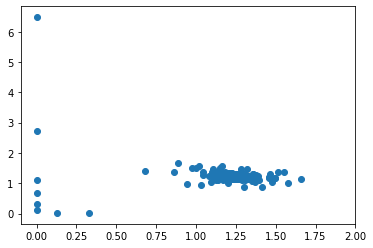

In [31]:
poiancare_step = 3
e_n_maxima = e_arr[e_local_maxima_ind[:-poiancare_step] ] 
e_n_plus_maxima = e_arr[e_local_maxima_ind[poiancare_step:]]
plt.scatter(e_n_maxima, e_n_plus_maxima)
plt.xlim(-0.1,2)

# Temporal correlation between theta states and current

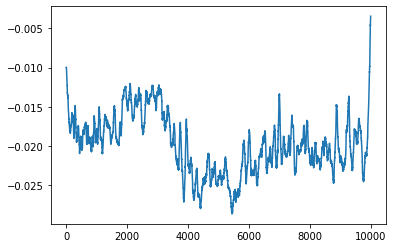

In [32]:
theta_e_corr = theta_e_product_sum/total_steps - theta_sum/total_steps * e_arr.mean()
plt.plot( theta_e_corr[np.argsort(random_input)] ) 

In [33]:
np.abs(theta_e_corr).max()

0.028664542532559865